## Importing The Libraries

In [2]:
import re
import numpy as np
import pandas as pd
import seaborn as sns
from bs4 import BeautifulSoup
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from spacy.lang.en.stop_words import STOP_WORDS as stopwords
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix

In [3]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense,Flatten,Embedding,Dropout
from keras.utils import to_categorical
from tensorflow.keras.layers import GRU, Bidirectional, BatchNormalization, Embedding,Dropout, Conv1D
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential

In [4]:
#suppressing the warnings
import tensorflow as tf
import logging
tf.get_logger().setLevel(logging.ERROR)
import warnings
warnings.filterwarnings('ignore')
plt.style.use('ggplot')

## Reading The Dataset

In [6]:
dataset = pd.read_csv('/content/toxicity_parsed_dataset.csv', engine='python')
dataset = dataset.drop(['index', 'ed_label_0','ed_label_1'], 1)
dataset.head(7)

,Text,oh_label
0,This: :One can make an analogy in mathematical...,0
1,` :Clarification for you (and Zundark's righ...,0
2,Elected or Electoral? JHK,0
3,`This is such a fun entry. Devotchka I once...,0
4,Please relate the ozone hole to increases in c...,0
5,`:In an interpreted language your source code ...,0
6,` I fixed the link; I also removed ``homeopa...,0


In [7]:
print(f'Shape of Dataset: {dataset.shape}')

Shape of Dataset: (159686, 2)


## Data Preprocessing

In [8]:
#adding new column and renaming the cell
dataset['Annotation'] = " "
dataset.loc[dataset['oh_label'] == 0, 'Annotation'] = 'Not Toxic'
dataset.loc[dataset['oh_label'] == 1, 'Annotation'] = 'Toxic'
dataset.sample(5)


,Text,oh_label,Annotation
77237,:So how long will this one last and who am i ...,0,Not Toxic
123094,== External link: Why imaginary numbers real...,0,Not Toxic
17789,The complaint was not that the international r...,0,Not Toxic
29681,"DUE TO MY INSANELY HIGH LEVEL OF WIKISTRESS, I...",1,Toxic
29343,2006 (UTC) :Hi Jorgenumata. I liked all the ...,0,Not Toxic


In [9]:
#balancing the dataset
d = dataset.groupby('oh_label')
dataset = d.apply(lambda x: x.sample(d.size().min()).reset_index(drop=True))

## Target Class Distribution Visualization 

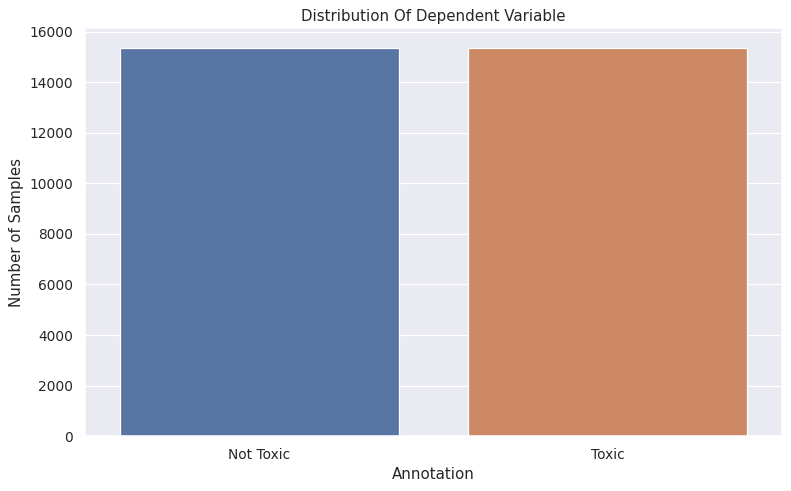

In [10]:
plt.rcParams['figure.figsize'] = [10,6]
plt.rcParams['figure.dpi'] = 90
sns.set(style='darkgrid')

sns.countplot('Annotation', data=dataset)
plt.ylabel("Number of Samples")
plt.title('Distribution Of Dependent Variable')
plt.show()

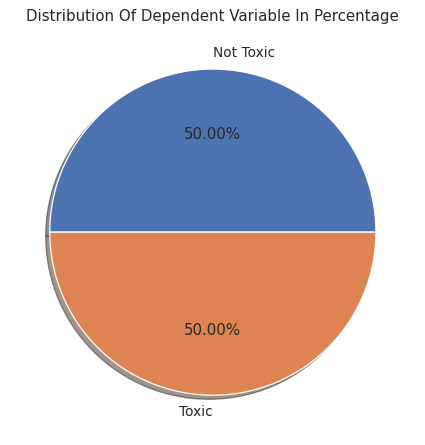

In [ ]:
dataset['Annotation'].value_counts().plot.pie(autopct='%1.2f%%', shadow=True)
plt.title('Distribution Of Dependent Variable In Percentage')
plt.ylabel("")
plt.show()

## Text Cleaning

In [11]:
!pip -q install contractions
import contractions
import unicodedata

     |████████████████████████████████| 327kB 7.3MB/s 
     |████████████████████████████████| 286kB 11.9MB/s 


In [12]:
def remove_accented(x):
  x = unicodedata.normalize('NFKD', x).encode('ascii', 'ignore').decode('utf-8', 'ignore')
  return x

In [13]:
#for removal of frequent and raer words
freq_comm = pd.Series(dataset['Text']).value_counts()
f20 = freq_comm[:50]
rare20 = freq_comm.tail(50)


In [15]:
def get_clean(X):
  X = str(X).lower()
  X = X.replace('\\', ' ').replace('_', ' ').replace('.', ' ').replace(':', '')
  X = re.sub(r'(http|https|ftp|ssh)://([\w_-]+(?:(?:\.[\w_-]+)+))([\w.,@?^=%&:/~+#-]*[\w@?^=%&/~+#-])?',"",  X)
  X = re.sub(r'\brt\b', '', X).strip()
  X = re.sub('<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});',"", X)
  X = re.sub(r'[^\w\d\s]+','', X)
  X = ' '.join(X.split())
  X = BeautifulSoup(X, 'lxml').get_text().strip()
  X = remove_accented(X)
  X = re.sub(r'[^\w ]+','',X)
  X = re.sub("(.)\\1{2,}", "\\1", X)
  X = contractions.fix(X)
  #X = ' '.join([word for word  in X.split() if word not in stopwords])
  X = ' '.join([word for word in X.split() if word not in f20]) 
  X = ' '.join([word for word in X.split() if word not in rare20])
  return X

In [16]:
dataset['Text'] = dataset['Text'].apply(lambda X : get_clean(X))
dataset = dataset[dataset['Text'].str.split().str.len().ge(3)]

## Word Cloud Representation

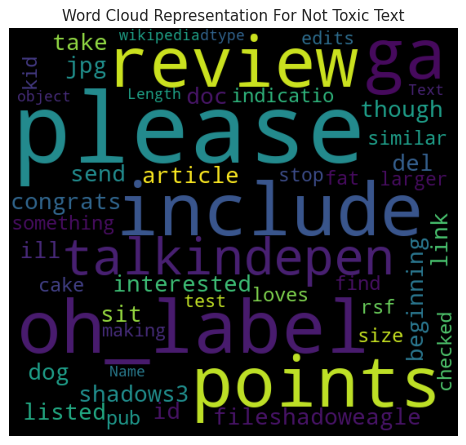

In [17]:
nottoxic = str(dataset[dataset['oh_label']==0].Text)
word_cloud = WordCloud(width=550, height=500, max_font_size=120).generate(nottoxic)
plt.imshow(word_cloud)
plt.title('Word Cloud Representation For Not Toxic Text')
plt.axis('off')
plt.show()

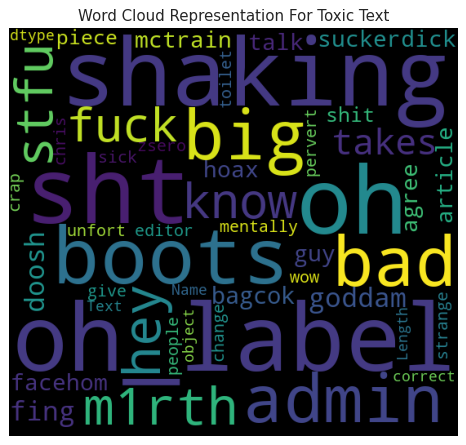

In [23]:
toxic = str(dataset[dataset['oh_label']==1].Text)
word_cloud = WordCloud(width=550, height=500, max_font_size=150).generate(toxic)
plt.imshow(word_cloud)
plt.title('Word Cloud Representation For Toxic Text')
plt.axis('off')
plt.show()

## Converting Text Into Machine Understandable Numeric Form

In [21]:
X = dataset['Text']
y = dataset['oh_label']
#y = to_categorical(y)

In [ ]:
#Tokenization
token = Tokenizer()
token.fit_on_texts(X)

In [ ]:
vocab_size = len(token.word_index) + 1
print('The size of vocab:', vocab_size)

The size of vocab: 69667


In [ ]:
encoded_text = token.texts_to_sequences(X)
max_length = len(X.max()) + 10  
X = pad_sequences(encoded_text, maxlen=max_length, padding='pre')

## Dividing The Data Into Train & Test

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0, stratify=y)

In [ ]:
print(f'Shape of traing Dataset: {X_train.shape, y_train.shape}')

Shape of traing Dataset: ((26399, 25), (26399,))


## Model Creation

In [ ]:
vec_size = 50

model = Sequential(name='GRU')

model.add(Embedding(vocab_size, vec_size, input_length=max_length))

model.add(Conv1D(60, 5, activation='relu'))
model.add(BatchNormalization())

model.add(GRU(units = 25, activation='relu', return_sequences=True))
model.add(BatchNormalization())


model.add(GRU(units = 50, activation='relu', return_sequences=True))
model.add(BatchNormalization())


model.add(Dense(200, activation='relu'))
model.add(BatchNormalization())

model.add(Dense(1, activation='sigmoid'))

## Model Understanding

In [ ]:
model.summary()

Model: "GRU"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_41 (Embedding)     (None, 25, 50)            3483350   
_________________________________________________________________
conv1d_17 (Conv1D)           (None, 21, 60)            15060     
_________________________________________________________________
batch_normalization_73 (Batc (None, 21, 60)            240       
_________________________________________________________________
gru_64 (GRU)                 (None, 21, 25)            6525      
_________________________________________________________________
batch_normalization_74 (Batc (None, 21, 25)            100       
_________________________________________________________________
gru_65 (GRU)                 (None, 21, 50)            11550     
_________________________________________________________________
batch_normalization_75 (Batc (None, 21, 50)            200     

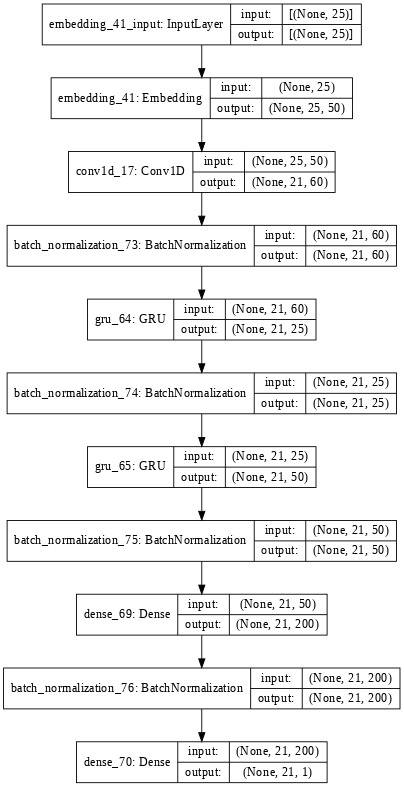

In [ ]:
plot_model(model, show_shapes=True, show_layer_names=True, dpi=64)

## Model Training

In [ ]:
#optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer= 'adam', loss='binary_crossentropy', metrics=['accuracy'])
r = model.fit(X_train, y_train, epochs=18)

Epoch 1/18
825/825 [==============================] - 55s 63ms/step - loss: 0.6295 - accuracy: 0.6355
Epoch 2/18
825/825 [==============================] - 52s 62ms/step - loss: 0.4204 - accuracy: 0.7722
Epoch 3/18
825/825 [==============================] - 52s 63ms/step - loss: 0.3396 - accuracy: 0.8125
Epoch 4/18
825/825 [==============================] - 52s 63ms/step - loss: 0.3133 - accuracy: 0.8191
Epoch 5/18
825/825 [==============================] - 52s 63ms/step - loss: 0.2936 - accuracy: 0.8293
Epoch 6/18
825/825 [==============================] - 52s 63ms/step - loss: 0.2856 - accuracy: 0.8328
Epoch 7/18
825/825 [==============================] - 52s 63ms/step - loss: 0.2806 - accuracy: 0.8350
Epoch 8/18
825/825 [==============================] - 52s 63ms/step - loss: 0.2720 - accuracy: 0.8396
Epoch 9/18
825/825 [==============================] - 52s 63ms/step - loss: 0.2715 - accuracy: 0.8398
Epoch 10/18
825/825 [==============================] - 52s 63ms/step - loss: 0.265

## Model Accuracy & Loss

In [ ]:
import math   
print(f'The traning accuracy of model is {math.floor(r.history["accuracy"][-1] * 100)} %')
print(f'The traning loss of model is {r.history["loss"][-1]:.4f}')

The traning accuracy of model is 85 %
The traning loss of model is 0.2519


In [ ]:
plt.rcParams['figure.figsize'] = [6,4]
plt.rcParams['figure.dpi'] = 80

## Model Accuracy Visualization

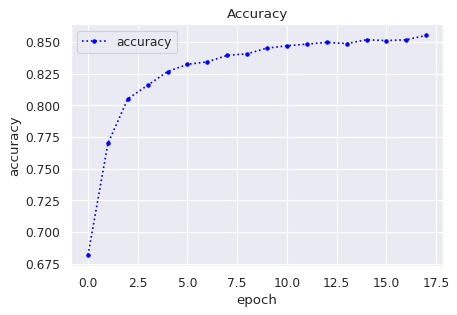

In [ ]:
plt.title('Accuracy')
plt.plot(r.history['accuracy'], ".:", label='accuracy', linewidth=1.5, color="blue")
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend()
plt.show()

## Model Loss Visualization

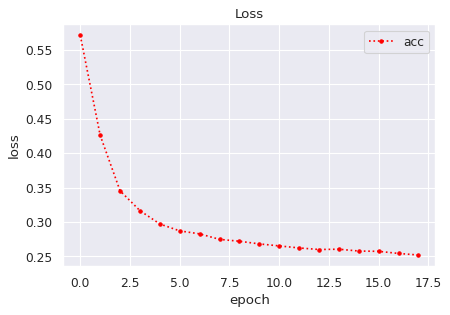

In [ ]:
plt.title('Loss')
plt.plot(r.history['loss'], ".:", label='acc', linewidth=1.5, color="red")
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()
plt.show()

## Model Evaluation

In [ ]:
results = model.evaluate(X_test, y_test)
print('----------------------------------------------------------------------------------------')
print(f"Test Loss: {results[0]:.3f}")
print("Test Accuracy: {} %".format(math.floor(results[1] * 100)))

92/92 [==============================] - 1s 7ms/step - loss: 0.9729 - accuracy: 0.7023
----------------------------------------------------------------------------------------
Test Loss: 0.973
Test Accuracy: 70 %


## Saving The Model

In [ ]:
model.save('Toxicity_Identification.h5')